In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from utils.preprocessing import create_time_matrix, create_caregivers_df, create_tasks_df, create_clients_df

caregivers = create_caregivers_df('data/raw/caregivers.csv')

tasks = create_tasks_df('data/raw/hemtjanst_tasks.csv', only_client_tasks=True)

clients = create_clients_df('data/raw/clients.csv')

drive_time_matrix = create_time_matrix('data/raw/matrix_duration_matrix_DRIVE.csv')
walk_time_matrix = create_time_matrix('data/raw/matrix_duration_matrix_WALK.csv')
bicycle_time_matrix = create_time_matrix('data/raw/matrix_duration_matrix_BICYCLE.csv')

In [2]:
# Test1: Subset with only caregivers 33, 949, 1108 and their tasks
test1_subset = [33, 949, 1108]
caregivers_test1 = caregivers.loc[test1_subset]
tasks_test1 = tasks[tasks['PlannedCaregiverID'].isin(test1_subset)]

print(f"Number of caregivers in subset: {len(caregivers_test1)}")
print(f"Number of tasks assigned to subset caregivers: {len(tasks_test1)}")

# Test2: Subset with only first 10 caregivers that use car as mode of transport
car_caregivers = caregivers[caregivers['ModeOfTransport'] == 'car']
caregivers_test2 = car_caregivers.head(10)
tasks_test2 = tasks[tasks['PlannedCaregiverID'].isin(caregivers_test2.index)]

print(f"Number of caregivers in subset: {len(caregivers_test2)}")
print(f"Number of tasks assigned to subset caregivers: {len(tasks_test2)}")

Number of caregivers in subset: 3
Number of tasks assigned to subset caregivers: 27
Number of caregivers in subset: 10
Number of tasks assigned to subset caregivers: 86


In [3]:
from models import flexible_model
model_caregivers = caregivers_test2
model_tasks = tasks_test2
model_flex, x_flex, t_flex = flexible_model.build_model(model_caregivers, model_tasks, clients, drive_time_matrix, walk_time_matrix, bicycle_time_matrix)

Set parameter Username
Set parameter LicenseID to value 2634432
Academic license - for non-commercial use only - expires 2026-03-10


In [4]:
model_flex.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D70)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 77507 rows, 75700 columns and 451520 nonzeros
Model fingerprint: 0x946ea09f
Variable types: 880 continuous, 74820 integer (74820 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 74911 rows and 42581 columns
Presolve time: 0.04s
Presolved: 2596 rows, 33119 columns, 100977 nonzeros
Variable types: 20 continuous, 33099 integer (33099 binary)
Performing another presolve...
Presolve removed 820 rows and 0 columns
Presolve time: 0.15s

Root relaxation: objective 0.000000e+00, 5628 iterations, 1.27 seconds (2.60 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap |

Model not optimally solved. Status: 11


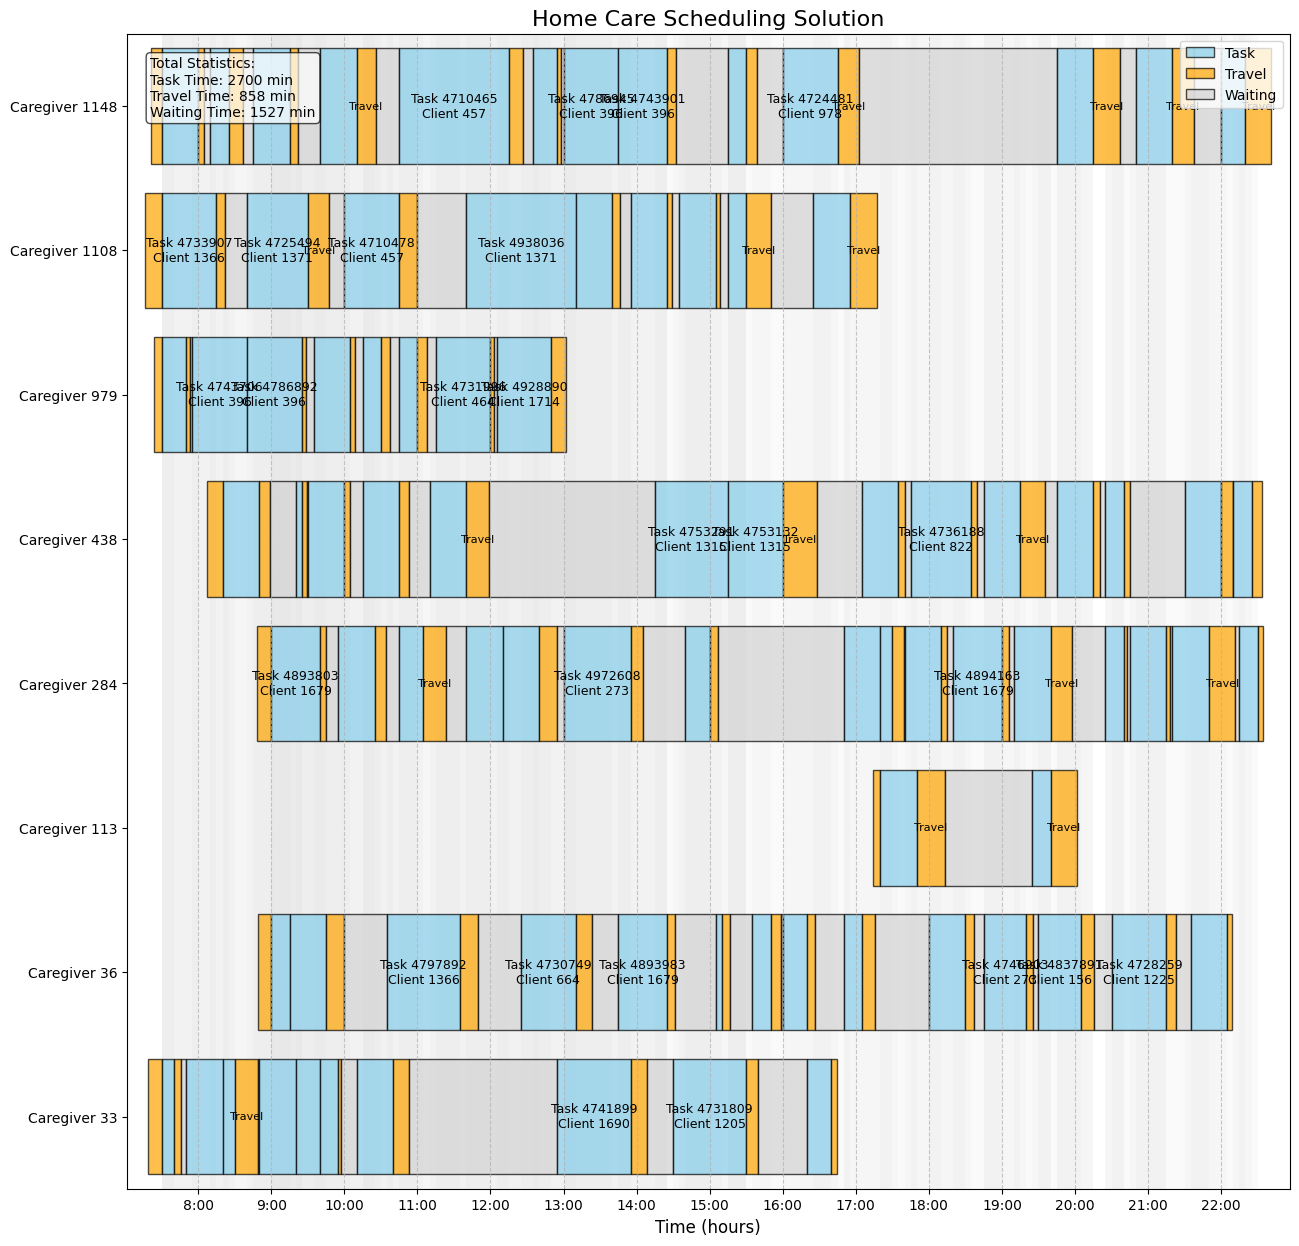

In [5]:
from utils.visualization import visualize_home_care_schedule
visualize_home_care_schedule(model_flex, x_flex, t_flex, model_caregivers, model_tasks, drive_time_matrix)